# Trabajo 2 Leonardo Rodriguez

### Creación base de datos chromaDB con persistencia

In [ ]:
import chromadb
client = chromadb.PersistentClient(path=".")

# Crear una nueva colección con dimensionalidad ajustada
doc_collection = client.create_collection(
    name="hidrogeno_verde_LeoR",
    metadata={"dimension": 1536}  # Dimensión específica para embeddings de OpenAI
)


### Cargar base de datos!!

In [1]:
import chromadb

# Inicializar cliente con persistencia
client = chromadb.PersistentClient(path=".")  # Asegúrate de que el path sea correcto

# Cargar colección existente
collection = client.get_or_create_collection("hidrogeno_verde_LeoR")

# Verificar el estado de la colección
num_docs = collection.count()
print(f"Documentos en la colección: {num_docs}")



Documentos en la colección: 148


### Preprocesar noticias y subirla a Chromadb

In [2]:
import pandas as pd
df = pd.read_csv('hidrogeno_verde.csv')
df.head()

,date,id_news,text,title,url,polarity_score,polarity_label,media_outlet,country
0,"Oct 19, 2024 @ 21:00:00.000",54.272.642,"Santiago, octubre de 2024 – Como parte de la c...",Ausenco impulsa la transición energética a tra...,https://tierramarillano.cl/2024/10/20/ausenco-...,-,-,tierraamarillano,chile
1,"Oct 17, 2024 @ 21:00:00.000",54.270.980,"Claudio Seebach, una voz respetada en el sect...","Claudio Seebach aterriza la ""realidad"" del hid...",https://www.emol.com/noticias/Economia/2024/10...,-,-,emol,chile
2,"Oct 16, 2024 @ 21:00:00.000",54.274.158,"En septiembre, el Presidente Gabriel Boric i...",Hidrógeno verde: La industria estratégica para...,https://www.emol.com/noticias/Economia/2024/10...,-,-,emol,chile
3,"Oct 14, 2024 @ 21:00:00.000",54.293.366,– Eliana Ximena Oyarzún Nancuante La División ...,Subpesca solicita a la industria del hidrógeno...,https://laprensaaustral.cl/2024/10/15/subpesca...,-,-,laprensaaustral,chile
4,"Oct 14, 2024 @ 21:00:00.000",54.293.490,– Eliana Ximena Oyarzún Nancuante Su profunda ...,Sindicato de Trabajadores Enap llama a “aterri...,https://laprensaaustral.cl/2024/10/15/sindicat...,-,-,laprensaaustral,chile


### ¿que metadatos extraer?
#### no se usaron todos, puede quedar la opción de agregar más herramientas que los usen 
    1- Fecha
    2- Medio
    3- titulo
    4- url
    5- Nombres mencionados
    6- lugares mecionados
    7- evento principal
    8- Sentimiento 
    9 - organizaciones mencionadas

In [4]:
def preprocesar_rango_noticias(dataset, rango_inicio, rango_fin, output_file="noticias_procesadas.csv"):
   
    import pandas as pd
    import spacy
    from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

    # Cargar modelos
    nlp = spacy.load("es_core_news_md")  # Modelo de spaCy para español
    summarizer = pipeline("summarization", model="t5-small", tokenizer="t5-small")  # Resumen automático

    model_name = "finiteautomata/beto-sentiment-analysis"
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

    # Cargar dataset
    df = pd.read_csv(dataset)

    # Seleccionar rango de noticias
    df_rango = df.iloc[rango_inicio:rango_fin].copy()  # Usar `.copy()` para evitar conflictos

    #print(df_rango['date'])
    df_rango['date'] = pd.to_datetime(df_rango['date'], format='%b %d, %Y @ %H:%M:%S.%f', errors='coerce')
    df_rango['date'] = df_rango['date'].apply(lambda x: int(x.timestamp()) if pd.notnull(x) else None)
    # importante fechas no tocar

    # Procesar noticias
    df_rango['titulo'] = df_rango['title'].str.strip()
    df_rango['medio'] = df_rango['media_outlet']
    df_rango['enlace'] = df_rango['url']

    # Extraer nombres mencionados y contar ocurrencias
    df_rango['nombres_mencionados'] = df_rango['text'].apply(lambda x: [ent.text for ent in nlp(x).ents if ent.label_ == "PER"])
    df_rango['conteo_nombres'] = df_rango['nombres_mencionados'].apply(lambda nombres: {nombre: nombres.count(nombre) for nombre in set(nombres)})

    # Extraer organizaciones mencionadas y contar ocurrencias
    df_rango['organizaciones_mencionadas'] = df_rango['text'].apply(lambda x: [ent.text for ent in nlp(x).ents if ent.label_ == "ORG"])
    df_rango['conteo_organizaciones'] = df_rango['organizaciones_mencionadas'].apply(lambda orgs: {org: orgs.count(org) for org in set(orgs)})

    # Extraer lugares mencionados
    df_rango['lugares_mencionados'] = df_rango['text'].apply(lambda x: [ent.text for ent in nlp(x).ents if ent.label_ in ["LOC", "GPE"]])

    # Extraer evento principal
    df_rango['evento_principal'] = df_rango['text'].apply(lambda x: summarizer(x, max_length=100, min_length=30, do_sample=False)[0]['summary_text'])

    # Analizar el sentimiento del evento principal
    df_rango['sentimiento'] = df_rango['evento_principal'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

    # drop a algunas cosas para limpiar
    df_rango = df_rango.drop('polarity_score',axis=1)
    df_rango = df_rango.drop('polarity_label',axis=1)

    # Guardar resultados en un nuevo archivo CSV
    df_rango.to_csv(output_file, index=False)
    print(f"Archivo guardado: {output_file}")

    return df_rango


In [ ]:
# Lo que se hace aqui es tomar un rango de noticias a preprocesar para acelerar el proceso
preprocesar_rango_noticias(
    dataset="hidrogeno_verde.csv", #Archivo de entrada
    rango_inicio=151,
    rango_fin=250,
    output_file="procesadas_151_250.csv" #Archivo de salida
)

### Implementar retriver Langchain -> ChromaDB

In [3]:
import chromadb
from langchain.embeddings import OpenAIEmbeddings
api_key = "reemplazar"
embeddings = OpenAIEmbeddings(openai_api_key=api_key)


C:\Users\leonardo\AppData\Local\Temp\ipykernel_5564\3662291841.py:4: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(openai_api_key=api_key)


In [4]:
import chromadb
client = chromadb.PersistentClient(path=".") 
doc_collection = client.get_or_create_collection("hidrogeno_verde_LeoR")

In [ ]:
import pandas as pd
import chromadb
import uuid
from langchain.embeddings.openai import OpenAIEmbeddings

# Función para almacenar documentos con metadatos en ChromaDB
def store_csv_in_chromadb():
    
    df = pd.read_csv("procesadas_151_250.csv") # Reemplazar con csv de noticias procesadas

    # Iterar sobre cada fila del csv
    for index, row in df.iterrows():
        texto = row['text']
        if not isinstance(texto, str) or texto.strip() == "":
            print(f"Fila {index}: el texto está vacío, se omite.")
            continue
        
        # Generar metadatos a partir del resto de columnas
        metadatos = row.drop(labels=['text']).to_dict()
        
        # Generar un UUID único para cada doc
        unique_id = str(uuid.uuid4())
        
        # Calcular embedding 
        embedding = embeddings.embed_query(texto)
        
        # Agregar el documento a ChromaDB
        doc_collection.add(
            ids=[unique_id],  # Usar UUID como ID único
            documents=[texto],  # Documento principal
            embeddings=[embedding],  # Embedding generado
            metadatas=[metadatos]  # Metadatos asociados
        )

    print("Ok!!")

store_csv_in_chromadb()


Ok!!


In [6]:
# Validar y ver 
num_docs = doc_collection.count()
print(f"Documentos en la colección: {num_docs}")
resultados = doc_collection.get()

# Iterar sobre los resultados y mostrarlos
for i in range(len(resultados["ids"])):
    print(f"ID: {resultados['ids'][i]}")
    print(f"Documento: {resultados['documents'][i]}")
    print(f"Metadatos: {resultados['metadatas'][i]}")
    print("-" * 40)


Documentos en la colección: 247
ID: 381b1c0f-d254-4693-9f42-1f05bdafe22a
Documento: Claudio Seebach,  una voz respetada en el sector energético nacional, abordó las dudas que se han despertado en distintos rincones del mundo respecto a la viabilidad del hidrógeno verde, un combustible que carga con la promesa de ser clave en la transición global hacia energías más limpias y por el cual Chile ha apostado con fuerza, decidido a levantar una industria que sea estratégica para el país y el mundo.  El camino para consolidar al hidrógeno verde como una alternativa energética competitiva para sacar del juego a los combustibles fósiles ha sido más rugoso del que se pensaba. Sus altos costos e incertidumbre respecto a la demanda mundial han espantado a algunos inversionistas, reflejándose en la paralización o el retraso de varias iniciativas alrededor del globo.  RelacionadasDetalle('1145749','1145696');  Seebach actualmente decano de la Facultad de Ingeniería y Ciencias de la U. Adolfo Ibáñez 

## Lanchain  Tools

In [7]:
from langchain.tools import Tool
from datetime import datetime

def buscar_por_embeddings(pregunta):
    # Calcular el embedding de la pregunta
    pregunta_embedding = embeddings.embed_query(pregunta)
    
    # Realizar la búsqueda en ChromaDB
    resultados = doc_collection.query(
        query_embeddings=[pregunta_embedding],
        n_results=3  #cantidad de retorno
    )
    
    # Formatear los resultados
    documentos_relevantes = [
        {"documento": doc, "metadatos": meta}
        for doc, meta in zip(resultados["documents"], resultados["metadatas"])
    ]
    #print(documentos_relevantes) # no tan bueno
    # Mejor incluir separador de noticias con strings
    r = ""
    for i in range(len(resultados["documents"][0])):
        r += f"Noticia {i+1} :"
        r += resultados["documents"][0][i] + " | "
        #print(resultados["metadatas"][0][i])

    return r  # se debe devolver string no lista ni diccoionarios
        

# Crear una Tool para LangChain
buscar_por_embeddings_tool = Tool(
    name="BuscarPorEmbeddings",
    func=lambda x: buscar_por_embeddings(x, doc_collection),  # doc_collection es la colección de ChromaDB
    description="Busca documentos relevantes en ChromaDB utilizando embeddings calculados de la pregunta."
)




In [69]:
# Test de la función
pregunta = "ministro de Energía, Diego Pardow"
response = buscar_por_embeddings(pregunta)

# Imprimir los documentos en response
print("\n",response)





 Noticia 1 :– Eliana Ximena Oyarzún Nancuante Encabezada por el ministro de Energía, Diego Pardow, y con la participación del gobernador de Magallanes, Jorge Flies, sesionó por primera vez el Comité Estratégico para el Plan de Acción de Hidrógeno Verde. La instancia que tiene como misión delinear los pilares que permitan trazar el despliegue de esta industria clave para el proceso de transición energética, comenzó su trabajo en la Casa Central de la Universidad de Chile, oportunidad en la cual el secretario de Estado llamó al grupo de expertos/as a conciliar ideas que permitan la construcción de una mirada común para el desarrollo de esta industria. “Lo que hemos visto durante la realización de los talleres ciudadanos del Plan de Acción de Hidrógeno Verde es que hay un consenso en un porcentaje importante de los temas abordados. Pero hay otra parte donde se refleja que existe una tensión y es necesario que esas tensiones las abordemos. Eso es precisamente el corazón de esta invitación

In [8]:
from langchain.agents import Tool, initialize_agent
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.agents import AgentType
import requests

# Función para búsqueda en ChromaDB
def chromadb_search(query):
    """
    Busca en ChromaDB documentos relevantes utilizando embeddings.
    """
    resultados = buscar_por_embeddings(query, doc_collection, top_n=3)  # Función previamente definida
    return "\n".join([f"Noticia {i+1}:\nDocumento: {doc['documento']}\nMetadatos: {doc['metadatos']}\n{'-'*20}" 
                      for i, doc in enumerate(resultados)])


In [9]:
from langchain.agents import Tool, initialize_agent
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.agents import AgentType
import requests

# Función para búsqueda en Wikipedia
def wikipedia_search(query):
    """
    Busca información en Wikipedia para el tema dado.
    """
    response = requests.get(f"https://es.wikipedia.org/w/api.php", params={
        "action": "query",
        "format": "json",
        "titles": query,
        "prop": "extracts",
        "exintro": True
    })
    pages = response.json().get('query', {}).get('pages', {})
    page = next(iter(pages.values()), {})
    return page.get('extract', "No se encontró información en Wikipedia.")

In [10]:
people = "Gabriel_Boric" #nobres seeparados con "_"
res = wikipedia_search(people)
print(res)
print("\n", type(res))

<p><b>Gabriel Boric Font</b> (Punta Arenas, 11 de febrero de 1986) es un político chileno, egresado de Derecho.<sup id="cite_ref-ams_7-0" class="reference separada"><span>[</span>7<span>]</span></sup>​<sup id="cite_ref-cnn_8-0" class="reference separada"><span>[</span>8<span>]</span></sup>​ Desde el 11 de marzo de 2022 es el presidente de la República de Chile.<sup id="cite_ref-9" class="reference separada"><span>[</span>9<span>]</span></sup>​
</p><p>Como estudiante de la Facultad de Derecho de la Universidad de Chile, fue presidente de su Federación de Estudiantes (FECh), durante el periodo 2011-2012, y uno de los principales dirigentes de las movilizaciones estudiantiles de 2011.<sup id="cite_ref-electo_10-0" class="reference separada"><span>[</span>10<span>]</span></sup>​ En las elecciones parlamentarias de 2013 fue electo como diputado por la Región de Magallanes por el entonces distrito n.º 60 para el período legislativo 2014-2018. Posteriormente en las elecciones parlamentarias d

In [44]:
from langchain.embeddings.openai import OpenAIEmbeddings
from datetime import datetime
#funcciona   # borrar db mañana y volver a preprocesar todo agregar fecha normal a metadatos
def buscar_noticias_por_tema_y_fecha(input_data):
    
    try:
        # Manejar entrada en formato cadena o diccionario
        if isinstance(input_data, str):
            input_args = {key.strip(): value.strip().strip('"') for key, value in 
                          (item.split('=') for item in input_data.split(','))}
        elif isinstance(input_data, dict):
            input_args = input_data
        else:
            return "Error: El formato de la entrada no es válido. Debe ser una cadena o un diccionario."

        # Obtener los parámetros
        tema = input_args['tema']
        fecha_inicio = input_args['fecha_inicio']
        fecha_fin = input_args['fecha_fin']

        # Validar formato de fechas
        datetime.strptime(fecha_inicio, '%Y-%m-%d')
        datetime.strptime(fecha_fin, '%Y-%m-%d')

        # Convertir las fechas a timestamps (enteros)
        timestamp_inicio = int(datetime.strptime(fecha_inicio, '%Y-%m-%d').timestamp())
        timestamp_fin = int(datetime.strptime(fecha_fin, '%Y-%m-%d').timestamp())

        # Asegurarte de que el modelo de embedding sea correcto
        embeddings = OpenAIEmbeddings(openai_api_key=api_key)  # Ajusta la clave API
        tema_embedding = embeddings.embed_query(tema)  # Aquí solo procesamos el tema como embedding

        # Llamar a la consulta con ChromaDB, ahora comparando las fechas como timestamps
        resultados = doc_collection.query(
            query_embeddings=[tema_embedding],  # Solo el tema se convierte en embedding
            where={
                "$and": [
                    {"date": {"$gte": timestamp_inicio}},  # Comparar con timestamp de inicio
                    {"date": {"$lte": timestamp_fin}}     # Comparar con timestamp de fin
                ]
            },
            n_results=10,
            include=["metadatas"]
        )

        # Verificar si hay resultados
        if not resultados['metadatas']:
            return "No se encontraron resultados para la consulta."

        noticias = [  # devolver el texto principal limita la cantidad de noticias a recuperar (se pasa el limite de chatgpt)
            f"Título: {meta.get('title', 'No disponible')}\n"
            f"Evento Principal: {meta.get('evento_principal', 'No disponible')}\n"
            f"Conteo de Nombres: {meta.get('conteo_nombres', 'No disponible')}\n"
            f"URL: {meta.get('url', 'No disponible')}"
            for result in resultados['metadatas']  # Iterar sobre los resultados
            for meta in result  # Acceder a los metadatos en cada resultado
        ]
        return "\n\n".join(noticias)

    except KeyError as e:
        return f"Error: Falta el argumento {str(e)} en la entrada."
    except ValueError as e:
        return f"Error: {str(e)}"
    except Exception as e:
        return f"Error inesperado: {str(e)}"


In [37]:
query = "tema=Eliana Ximena Oyarzún, fecha_inicio=2023-10-05, fecha_fin=2024-11-02"
resultados = buscar_noticias_por_tema_y_fecha(query)
print(resultados)

Título: Estudiantes magallánicos presentaron prototipo de buque a hidrógeno verde en certamen internacional
Evento Principal: el profesor Javier Garay Miranda presentaron un innovador prototipo de buque impulsado por hidrógeno verde, denominado Lord Antártico . hecho de que nuestros estudiantes hayan sido invitados a esta feria .
Conteo de Nombres: {'Armando Quezada Acharán': 1, 'Javier Garay Miranda': 1, 'Pablo': 1, 'Garay': 2, 'Pablo Toledo Villarroel': 1, 'Magallanes': 1, 'Eliana Ximena Oyarzún Nancuante': 1, 'Lord Antártico': 1}


Título: Más de 300 asistentes en primera jornada de seminario de Hidrógeno Verde 2024
Evento Principal: Eliana Ximena Oyarzn Nancuante Haban poco más de 300 sillas dispuestas para los asistentes . la ocasión se presenta como una diversidad de invitados de distintas áreas, abriendo las charlas el Dr. Erwin Plett, consejero nacional
Conteo de Nombres: {'Total Eren': 1, 'Liane': 1, 'Mario Marchese': 1, 'Dr. Erwin Plett': 1, 'Antoine Liane': 1, 'Eliana Ximena

71     Nov 1, 2023 @ 21:00:00.000
72    Oct 26, 2023 @ 21:00:00.000
73    Oct 22, 2023 @ 21:00:00.000
74    Oct 21, 2023 @ 21:00:00.000
75    Oct 20, 2023 @ 21:00:00.000
76    Oct 20, 2023 @ 21:00:00.000
77    Oct 11, 2023 @ 21:00:00.000
78    Oct 11, 2023 @ 21:00:00.000
79     Oct 8, 2023

In [13]:
import ast
from langchain.embeddings.openai import OpenAIEmbeddings

def conteo_de_personas(tema):
    try:
        
        embeddings = OpenAIEmbeddings(openai_api_key=api_key)  # Ajusta la clave API
        tema_embedding = embeddings.embed_query(tema)

        resultados = doc_collection.query(
            query_embeddings=[tema_embedding],
            n_results=3,
            include=["metadatas"]
        )

        if not resultados["metadatas"]:
            return f"No se encontraron noticias relacionadas con el tema '{tema}'."

        # Acumular el conteo de personas
        conteo_total = {}
        noticias = []
        cont = 1
        for i, meta_list in enumerate(resultados["metadatas"], start=1):
            # Cada elemento de resultados["metadatas"] es una lista; iterar sobre sus diccionarios
            for meta in meta_list:
                # Procesar conteo de personas
                if "conteo_nombres" in meta:
                    try:
                        conteo_nombres = ast.literal_eval(meta["conteo_nombres"])  # Convertir el string del metadato a un dict
                    except (ValueError, SyntaxError):
                        conteo_nombres = {}

                    for nombre, conteo in conteo_nombres.items():
                        conteo_total[nombre] = conteo_total.get(nombre, 0) + conteo

                # Formatear la noticia
                titulo = meta.get('titulo', 'Sin título')
                evento_principal = meta.get('evento_principal', 'Sin evento principal')
                conteo_nombres_texto = meta.get('conteo_nombres', 'Sin datos de conteo de personas')

                noticia_formateada = f"noticia {cont}: {titulo}, {evento_principal}, conteo personas: {conteo_nombres_texto}."
                noticias.append(noticia_formateada)
                cont += 1

        # Formatear los resultados
        noticias_resumen = " ".join(noticias)
        if not conteo_total:
            conteo_personas_resumen = f"No se encontraron personas mencionadas en las noticias relacionadas con '{tema}'."
        else:
            conteo_personas_resumen = "\n".join([f"{nombre}: {conteo}" for nombre, conteo in sorted(conteo_total.items(), key=lambda x: -x[1])])

        return (
            #f"Conteo de menciones por persona en el tema '{tema}':\n\n{conteo_personas_resumen}\n\n"
            f"Resumen de noticias relacionadas:\n\n{noticias_resumen}"   # cambiar según conveniencia, funca!!
        )

    except Exception as e:
        return f"Error inesperado: {str(e)}"





In [14]:
pregunta = "Hidrogeno verde"
response = conteo_de_personas(pregunta)
print(response)
print(type(response))

Resumen de noticias relacionadas:

noticia 1: Gobierno anuncia plan de 81 medidas para desarrollar industria de hidrógeno verde, 81 medidas que se implementarán tanto a corto plazo como otras fijadas para la próxima decada . hidrógeno verde es una fuente de energa utilizada para la producción de electricidad y calor y su caracterstica principal ., conteo personas: {'Gabriel Boric': 1, 'Boric': 1}. noticia 2: ¿Qué es el Hidrógeno Verde? Cómo se produce y por qué es tan importante para el Estado de Chile, el hidrógeno verde se posiciona como una oportunidad para transformar su matriz energética, destacando su potencial para crear empleos y mejorar las condiciones de vida . a pesar de la baja demanda actual, se enfrenta al recurso crezca, abriendo, conteo personas: {'Según el Gobierno': 1}. noticia 3: Inauguran equipo único en Latinoamérica para el desarrollo de investigación sobre hidrógeno verde, el hidrógeno verde tiene una particularidad, que llega a lugares donde otras tecnologas sos

In [15]:
import ast
def buscar_por_persona(nombre_persona):
    try:
        generico = "Hidrogeno verde"
        embeddings = OpenAIEmbeddings(openai_api_key=api_key)
        tema_embedding = embeddings.embed_query(generico)

        resultados = doc_collection.query(
            query_embeddings=tema_embedding,
            include=["documents", "metadatas"],
            n_results=5
        )

        if not resultados["documents"]:
            return f"No se encontraron noticias en la base de datos."

        noticias_filtradas = []
        for doc, metas in zip(resultados["documents"], resultados["metadatas"]):
            for meta in metas:  # Iterar sobre la lista interna de metadatos
                if "nombres_mencionados" in meta:
                    try:
                        nombres_mencionados = ast.literal_eval(meta["nombres_mencionados"])
                    except (ValueError, SyntaxError):
                        continue  # Ignorar metadatos mal formateados

                    if nombre_persona in nombres_mencionados:
                        noticias_filtradas.append({
                            "titulo": meta.get("title", "No disponible"),
                            "url": meta.get("url", "No disponible"),
                            "evento_principal": meta.get("evento_principal", "No disponible"),
                            "nombres_mencionados": ", ".join(nombres_mencionados)
                        })

        if not noticias_filtradas:
            return f"No se encontraron noticias donde se mencione a '{nombre_persona}'."

        resultado_final = "\n".join([
            f"Título: {noticia['titulo']}\n"
            f"URL: {noticia['url']}\n"
            f"Evento principal: {noticia['evento_principal']}\n"
            f"Nombres mencionados: {noticia['nombres_mencionados']}\n"
            for noticia in noticias_filtradas
        ])
        return resultado_final

    except Exception as e:
        return f"Error inesperado: {str(e)}"

In [33]:
pregunta = "Juan Carlos Jobet"
response = buscar_por_persona(pregunta)
print(response)
print(type(response))

Título: Reportaje: Hidrógeno verde, mucho marketing y poco verde
URL: https://www.elciudadano.com/actualidad/reportaje-hidrogeno-verde-mucho-marketing-y-poco-verde/12/05/
Evento principal: el hidrógeno verde se produce a partir de agua y las llamadas energa, porque es muy caro, por lo tanto, hay que fabricarlo y a travé de la tecnologa .
Nombres mencionados: Sebastián Piñera, Juan Carlos Jobet, Ricardo Lagos, Vivianne Blanlot, Marcelo Mena, Gonzalo Muñoz, Klaus Schmidt- Hebbe, Jeannette von Wolfersdorff, Gabriel Boric, José Miguel Benavente, Lucio Cuenca, Vilma Mellado, Carlos Bonifetti, Países, Gabriel Boric, Boric, Lucio Cuenca, Vilma Mellado, Agrega Mellado, Lamentablemente, Carlos Bonifetti, Presidente, Boric

<class 'str'>


### Reemplazar api de google porque cobran despues de x usos

Yes but in a weird way. Create a custom search endpoint with https://programmablesearchengine.google.com/controlpanel/create and get your API key.

Select "search the entire web" and "image search."

Then you can use https://developers.google.com/custom-search/v1/using_rest with searchType=image.

See also https://developers.google.com/custom-search/v1/reference/rest/v1/cse/list

"Custom Search JSON API provides 100 search queries per day for free. If you need more, you may sign up for billing in the API Console. Additional requests cost $5 per 1000 queries, up to 10k queries per day."

fuente: https://www.reddit.com/r/googlecloud/comments/126efns/is_the_google_images_api_still_available/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button


In [17]:
import requests
from PIL import Image
from IPython.display import display

def buscar_y_mostrar_imagen(nombre_persona, nombre_archivo="imagen_resultado.jpg"):
    api_google = "pedirmela en caso de usar o seguir tutorial anterior"
    # Configuración de la API
    api_key = api_google  # Reemplaza con tu clave API de Google
    search_engine_id = "908a9f9ba659c4297"  # Tu Search Engine ID de Google Custom Search
    url = "https://www.googleapis.com/customsearch/v1"
    
    # Parámetros de la búsqueda
    params = {
        "key": api_key,
        "cx": search_engine_id,
        "q": nombre_persona,
        "searchType": "image",
        "num": 1,  # Número de resultados a devolver
    }

    try:
        # Realizar la consulta
        response = requests.get(url, params=params)
        response.raise_for_status()
        
        results = response.json()
        if "items" in results and len(results["items"]) > 0:
            # Obtener la URL de la primera imagen
            url_imagen = results["items"][0]["link"]
            
            # Descargar la imagen
            img_response = requests.get(url_imagen, stream=True)
            img_response.raise_for_status()
            
            # Guardar la imagen localmente
            with open(nombre_archivo, "wb") as f:
                f.write(img_response.content)
            
            # Mostrar la imagen en el notebook
            imagen = Image.open(nombre_archivo)
            display(imagen)
            
            return f"Imagen encontrada y guardada como '{nombre_archivo}'. URL: {url_imagen}"
        else:
            return "No se encontraron imágenes para la consulta."
    
    except Exception as e:
        return f"Error: {str(e)}"


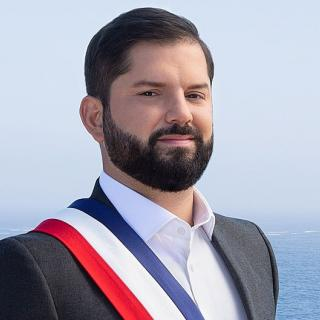

Imagen encontrada y guardada como 'imagen_resultado.jpg'. URL: https://acuerdodeescazu.cepal.org/cop3/sites/acuerdodeescazucop3/files/styles/person_picture/public/images/retrato_oficial_presidente_boric_font.jpg?itok=F6WQ2XR4


In [18]:
r = buscar_y_mostrar_imagen("Gabril Boric")
print(r)

In [45]:
from langchain.agents import Tool, initialize_agent
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.agents import AgentType
import requests
from langchain.memory import ConversationBufferWindowMemory
llm = ChatOpenAI(temperature=0.7, openai_api_key=api_key)

# Crear las herramientas
tools = [
    Tool(
        name="buscar_por_embeddings",
        func=buscar_por_embeddings,
        description="""
            Busca documentos relevantes en ChromaDB utilizando embeddings calculados de la pregunta.
            Cuando llames a esta herramienta el Action Input es solo el texto de la pregunta en string.
        """
    ),
    Tool(
        name="Wikipedia Search",
        func=wikipedia_search,
        description="""
            Consulta Wikipedia para obtener un resumen sobre el tema.
            Si lo que buscarás es a una persona el action input es de la foma: Nombre_Apellido
        """
    ),
    Tool(
        name = "buscar_noticias_por_tema_y_fecha",
        func = buscar_noticias_por_tema_y_fecha,
        description = """
            Busca documentos relevantes entre un rango de fechas.
            cuando la llames el action input es un string como este: "tema=Eliana Ximena Oyarzún, fecha_inicio=2023-10-05, fecha_fin=2024-11-02"
        """
    ),
    Tool(
        name = "conteo_de_personas",
        func = conteo_de_personas,
        description="""
        Devuelve un conteo de cuantas veces se nombra a ciertas personas en noticias de x tematica.
        el action input es un string del tema a buscar 
        """
    ),
    Tool(
        name = "buscar_por_persona",
        func = buscar_por_persona,
        description = """
        Devuelve noticias que mencionen a x persona
        el action input es de la forma: "Nombre Apellido"
        """
    ),
    Tool(
        name = "buscar_y_mostrar_imagen",
        func=buscar_y_mostrar_imagen,
        description="""Busca y reporta el url de una imagen relacioanada al action input.
        el action input debe ser un string.
        """
    )
]

# Definir el prompt usando PromptTemplate
prompt_template = """
Eres un agente que responde en español, que puede interactuar con herramientas para obtener información relevante y responder preguntas. 
Tienes acceso a estas herramientas principales:

1. **buscar_por_embeddings**: Busca en una base de datos de documentos para obtener información relevante.
2. **Wikipedia Search**: Realiza una consulta a Wikipedia para obtener un resumen sobre un tema.
3. **buscar_noticias_por_tema_y_fecha**: busca noticias relevantes entre 2 fechas proporcionadas.
4. ** conteo_de_personas **: busca noticias por tematica y devuelve el conteo de veces que es mencionada una persona.
5. **buscar_por_persona**: busca noticias por el nombre en los metadatos,
6. **buscar_y_mostrar_imagen**: busca la imagen relacionado al string action input

Cuando recibas una pregunta, sigue solo una de estas opciones, evalua tu cual tomar, según la pregunta:

a) si recibes una pregunta del tipo : "¿Que noticias hay de la tematica x entre las fechas A y B" sigue los siguientes pasos:
    1. usa funcion y **buscar_noticias_por_tema_y_fecha** y dale los parametros de esta forma:
    2. Luego de haber recuperado las noticias, genera como respuesta una lista de noticias, cada una debe
    llevar su titular, un pequeño resumen y el url

b) si recibes una pregunta del tipo : "¿Cuantas personas son mencionadas en noticias de x tematica entre 2 fechas"
	1. Usa la función **buscar_noticias_por_tema_y_fecha**
	2. responde a la pregunta con lo recogido en el paso anterior
	
c) si recibes una pregunta del tipo: "¿Que noticias hay donde aparezca x persona?"
	1. Usa la funcion **buscar_por_persona**
	2. devuelve una lista de noticias, donde cada noticia lleva su titular, un pequeño resumen y el url

d) si recibes una pregunta del tipo: "¿Que sabes de x persona? / ¿quien es x persona?"
	1. usa la función **buscar_por_persona**
	2. usa **wikipedia search**: debes darle el parametro de la forma "Nombre_Apellido" 
	3. formula una respuesta con lo recuperado.
    4. Usa la función ***buscar_y_mostrar_imagen*** pasandole un action input string 

e) si recibes una pregunta del tipo : "Muestrame una foto de x persona":
    1. usa **wikipedia search**: debes darle el parametro de la forma "Nombre_Apellido" 
    2. Usa la función ***buscar_y_mostrar_imagen*** pasandole un action input string 
	3. formula una respuesta con lo recuperado.
    
f) si recibes una pregunta que no cabe en ninguno de los casos anteriores:
	1. buscar_por_embeddings
	2. usa **wikipedia search**
	
Tu respuesta debe ser concisa y precisa.
---

### Instrucciones generales:
- Evalúa cuidadosamente la pregunta y selecciona **solo una** de las opciones anteriores según el caso.
- Asegúrate de que tu respuesta sea:
  - Clara y bien organizada.
  - extensa y explicativa.
  - Basada únicamente en la información recuperada de las herramientas.
"""

# Crear el PromptTemplate
prompt = PromptTemplate(input_variables=["query"], template=prompt_template)
memory = ConversationBufferWindowMemory(k=5)
# Crear el agente usando `initialize_agent`
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    memory = memory,
    handle_parsing_errors = True,
    verbose=True
)




# Preguntas tarea

### ¿Cuales son las personas que más se mencionan entre dos fechas sobre la temática del hidrogeno verde?

In [114]:
# Ejecutar el agente con una consulta
query = "¿Cuales son las personas que más se mencionan entre 01/10/2024 y el 30/11/2024 sobre la temática del hidrogeno verde?"
response = agent.run(query)

# Mostrar la respuesta
print(response)



> Entering new AgentExecutor chain...
Necesitamos encontrar las personas más mencionadas en noticias relacionadas con el hidrógeno verde en un rango de fechas específico.
Action: buscar_noticias_por_tema_y_fecha
Action Input: "tema=hidrogeno verde, fecha_inicio=2024-10-01, fecha_fin=2024-11-30"
Observation: Título: Bloomberg: El entusiasmo por el hidrógeno verde se desvanece ante altos costos
Conteo de Nombres: {'Nel ASA': 1, 'Liebreich': 2, 'Michael Liebreich': 1, 'Frank Calabria': 1, 'Liebreich Associates': 1}
URL: https://www.emol.com/noticias/Economia/2024/10/03/1144416/hidrogeno-verde-precio.html

Título: Hidrógeno verde: La industria estratégica para el futuro de Chile enfrenta dudas globales sobre su viabilidad
Conteo de Nombres: {'Piñera': 1, 'Roxana Shafiee': 1, 'Nel ASA': 1, 'Godoy': 4, 'Rodrigo Cáceres': 1, 'Fischer': 1, 'Ronald Fischer  Cáceres': 1, 'Álex Godoy': 1, 'Joule': 1, 'Bryce': 2, 'Álex Godoy  Godoy': 1, 'Presidente': 2, 'Ronald Fischer': 1, 'Frank Calabria': 1, 

### ¿Quién es “Juan Carlos Jobet”?



> Entering new AgentExecutor chain...
I should search for information about Juan Carlos Jobet to provide a brief summary of who he is.
Action: Wikipedia Search
Action Input: Juan Carlos Jobet
Observation: <p><b>Juan Carlos Jobet Eluchans</b> (Santiago, 14 de octubre de 1975) es un ingeniero comercial y político chileno. Se desempeñó como ministro de Energía desde junio de 2019, y como ministro de Minería desde diciembre de 2020, asumiendo simultáneamente ambos cargos como biministro de Estado de su país hasta marzo de 2022, bajo el segundo gobierno del presidente Sebastián Piñera. Entre julio de 2013 y marzo de 2014 ejerció como ministro del Trabajo y Previsión Social, durante el primer gobierno de Piñera.
</p>
Thought:I have found relevant information about Juan Carlos Jobet, including his political career and positions in the Chilean government.
Action: buscar_por_persona
Action Input: Juan Carlos Jobet
Observation: Título: Reportaje: Hidrógeno verde, mucho marketing y poco verde
U

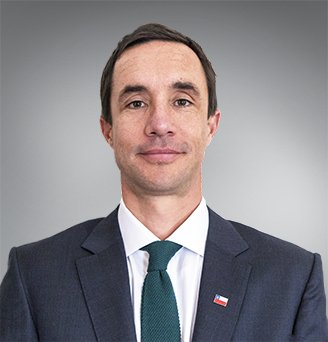


Observation: Imagen encontrada y guardada como 'imagen_resultado.jpg'. URL: https://upload.wikimedia.org/wikipedia/commons/6/6e/JUAN_CARLOS_JOBET.jpg
Thought:I have gathered relevant information about Juan Carlos Jobet, including his political career and involvement in green hydrogen production.
Final Answer: Juan Carlos Jobet is a Chilean engineer and politician who has held various ministerial positions in the Chilean government, including Minister of Energy and Minister of Mining.

> Finished chain.
Juan Carlos Jobet is a Chilean engineer and politician who has held various ministerial positions in the Chilean government, including Minister of Energy and Minister of Mining.


In [23]:
# Ejecutar el agente con una consulta
query = "¿Quién es Juan Carlos Jobet?"
response = agent.run(query)
# Mostrar la respuesta
print(response)

### ¿Cuál su opinión o su posición sobre el hidrógeno verde?

In [24]:
# Ejecutar el agente con una consulta
query = "¿Cuál su opinión de Juan Carlos Jobet sobre el hidrógeno verde?"
response = agent.run(query)
# Mostrar la respuesta
print(response)



> Entering new AgentExecutor chain...
Necesitamos buscar información específica sobre la opinión de Juan Carlos Jobet sobre el hidrógeno verde.
Action: buscar_por_persona
Action Input: "Juan Carlos Jobet"
Observation: Título: Reportaje: Hidrógeno verde, mucho marketing y poco verde
URL: https://www.elciudadano.com/actualidad/reportaje-hidrogeno-verde-mucho-marketing-y-poco-verde/12/05/
Evento principal: el hidrógeno verde se produce a partir de agua y las llamadas energa, porque es muy caro, por lo tanto, hay que fabricarlo y a travé de la tecnologa .
Nombres mencionados: Sebastián Piñera, Juan Carlos Jobet, Ricardo Lagos, Vivianne Blanlot, Marcelo Mena, Gonzalo Muñoz, Klaus Schmidt- Hebbe, Jeannette von Wolfersdorff, Gabriel Boric, José Miguel Benavente, Lucio Cuenca, Vilma Mellado, Carlos Bonifetti, Países, Gabriel Boric, Boric, Lucio Cuenca, Vilma Mellado, Agrega Mellado, Lamentablemente, Carlos Bonifetti, Presidente, Boric

Thought:Encontramos información relevante sobre la opini

### ¿Qué déclaraciones ha realizado en el contexto del hidrógeno verde?

In [46]:
# Ejecutar el agente con una consulta
query = "¿Qué déclaraciones ha realizado Juan Carlos Jobet sobre el hidrógeno verde?"
response = agent.run(query)
# Mostrar la respuesta
print("\n",response)



> Entering new AgentExecutor chain...
Primero buscaremos información relevante sobre las declaraciones de Juan Carlos Jobet sobre el hidrógeno verde en noticias recientes.
Action: buscar_noticias_por_tema_y_fecha
Action Input: "tema=Juan Carlos Jobet, hidrógeno verde, fecha_inicio=2023-01-01, fecha_fin=2024-11-02"
Observation: Error: not enough values to unpack (expected 2, got 1)
Thought: Parece que el formato del input para la búsqueda de noticias está incorrecto. Intentemos buscar directamente información en Wikipedia sobre Juan Carlos Jobet y el hidrógeno verde.
Action: Wikipedia Search
Action Input: Juan Carlos Jobet
Observation: <p><b>Juan Carlos Jobet Eluchans</b> (Santiago, 14 de octubre de 1975) es un ingeniero comercial y político chileno. Se desempeñó como ministro de Energía desde junio de 2019, y como ministro de Minería desde diciembre de 2020, asumiendo simultáneamente ambos cargos como biministro de Estado de su país hasta marzo de 2022, bajo el segundo gobierno del p

### Dame el enlace de una foto de Juan Carlos Jobet



> Entering new AgentExecutor chain...
Primero, debo buscar una imagen de Juan Carlos Jobet para proporcionar el enlace.
Action: buscar_y_mostrar_imagen
Action Input: "Juan Carlos Jobet"

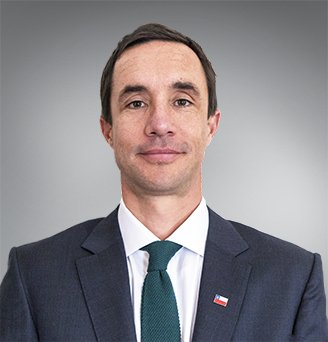


Observation: Imagen encontrada y guardada como 'imagen_resultado.jpg'. URL: https://upload.wikimedia.org/wikipedia/commons/6/6e/JUAN_CARLOS_JOBET.jpg
Thought:He encontrado la imagen de Juan Carlos Jobet y he guardado el enlace.
Final Answer: El enlace de una foto de Juan Carlos Jobet es https://upload.wikimedia.org/wikipedia/commons/6/6e/JUAN_CARLOS_JOBET.jpg

> Finished chain.

 El enlace de una foto de Juan Carlos Jobet es https://upload.wikimedia.org/wikipedia/commons/6/6e/JUAN_CARLOS_JOBET.jpg


In [29]:
query = "Dame el enlace de una foto de Juan Carlos Jobet"
response = agent.run(query)
# Mostrar la respuesta
print("\n",response)

### ¿Quienes son las personas más mencionadas en las noticias entre dos fechas?

In [ ]:
query = "¿Quienes son las personas más mencionadas en las noticias entre 01/08/2024 y el 30/10/2024?"
response = agent.run(query)
# Mostrar la respuesta
print("\n",response)



> Entering new AgentExecutor chain...
I should use the tool "buscar_noticias_por_tema_y_fecha" to search for relevant documents within the specified date range and then use "conteo_de_personas" to see who are the most mentioned individuals.
Action: buscar_noticias_por_tema_y_fecha
Action Input: "tema=noticias, fecha_inicio=2024-08-01, fecha_fin=2024-10-30"
Observation: Título: Sindicato de Trabajadores Enap llama a “aterrizar” las expectativas sobre los proyectos de hidrógeno verde
Conteo de Nombres: {'Eliana Ximena Oyarzún Nancuante': 1, 'Pardow': 1}
URL: https://laprensaaustral.cl/2024/10/15/sindicato-de-trabajadores-enap-llama-a-aterrizar-las-expectativas-sobre-los-proyectos-de-hidrogeno-verde/

Título: Hidrógeno verde: La industria estratégica para el futuro de Chile enfrenta dudas globales sobre su viabilidad
Conteo de Nombres: {'Piñera': 1, 'Roxana Shafiee': 1, 'Nel ASA': 1, 'Godoy': 4, 'Rodrigo Cáceres': 1, 'Fischer': 1, 'Ronald Fischer  Cáceres': 1, 'Álex Godoy': 1, 'Joule': 